In [2]:
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle
import glob
import os

from typing import Optional, Sequence
from datetime import timedelta
from google.oauth2 import service_account
from sklearn.cluster import KMeans  

from google.cloud import videointelligence as vi
from google.cloud import storage

/home/shyann/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [22]:
dir = os.getcwd()
raw_data_dir = f'{dir}/raw_data'
export_path = f'{dir}/data'

In [4]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/home/shyann/code/seshyblack/live2eat/notebooks/lewagon-livetoeat-d53331dc5e74.json'

In [14]:
video_uri='gs://live2eat-bootcamp/Dish Videos/Bak Chor Mee.mp4'

In [15]:
def track_objects(
    video_uri: str,
    segments: Optional[Sequence[vi.VideoSegment]] = None
) -> vi.VideoAnnotationResults:

    video_client = vi.VideoIntelligenceServiceClient()
    features = [vi.Feature.OBJECT_TRACKING]
    context = vi.VideoContext(segments=segments)
    request = vi.AnnotateVideoRequest(
        input_uri=video_uri,
        features=features,
        video_context=context,
    )
    print(f'Processing video "{video_uri}"...')

    operation = video_client.annotate_video(request)
    return operation.result().annotation_results[0]


In [5]:
results = track_objects(video_uri)

Processing video "gs://live2eat-bootcamp/Dish Videos/Bak Chor Mee.mp4"...


In [7]:
with open( "results.p", "wb" ) as f:
	pickle.dump( results, f)

In [16]:
with open( "results.p", "rb" ) as f:
	results = pickle.load(f)

In [17]:
def print_object_frames(
    results: vi.VideoAnnotationResults, entity_id: str, min_confidence: float = 0.7
):
    
    def keep_annotation(annotation: vi.ObjectTrackingAnnotation) -> bool:
        return all(
            [
                annotation.entity.entity_id == entity_id,
                min_confidence <= annotation.confidence,
            ]
        )

    annotations = results.object_annotations
    annotations = [a for a in annotations if keep_annotation(a)]
    object_frames = []
    
    for annotation in annotations:
   
        for frame in annotation.frames:
            t = frame.time_offset.total_seconds()
            object_frames.append(t)
                       
    return object_frames

In [18]:
food_entity_id = '/m/02wbm'
food_times=print_object_frames(results,food_entity_id)

In [19]:
# Read video and save to /tmp directory

last_path = os.sep.join(os.path.normpath(video_uri).split(os.sep)[-2:])
bucket = storage.Client().bucket('live2eat-bootcamp')
blob = bucket.blob(last_path)
blob.download_to_filename('/tmp/video.mp4')

# Video processing stuff
cam = cv2.VideoCapture('/tmp/video.mp4')

In [21]:
try:
    # creating a folder named data
    if not os.path.exists('raw_data'):
        os.makedirs('raw_data')
  
# if not created then raise error
except OSError:
    print ('Error: Creating directory of data')


for time in food_times:

    # reading from frame
    ret,frame = cam.read()

    capture_time = time*1000

    cam.set(cv2.CAP_PROP_POS_MSEC, capture_time)

    name = './raw_data/' + str(capture_time) + '.jpg'
    print ('Creating...' + name)

    # writing the extracted images
    cv2.imwrite(name, frame)
  
# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()

Creating..../raw_data/45200.0.jpg
Creating..../raw_data/45300.0.jpg
Creating..../raw_data/45400.0.jpg
Creating..../raw_data/45500.0.jpg
Creating..../raw_data/45600.0.jpg
Creating..../raw_data/45700.0.jpg
Creating..../raw_data/45800.0.jpg
Creating..../raw_data/45900.0.jpg
Creating..../raw_data/46000.0.jpg
Creating..../raw_data/46100.0.jpg
Creating..../raw_data/46200.0.jpg
Creating..../raw_data/46300.0.jpg
Creating..../raw_data/46400.0.jpg
Creating..../raw_data/46500.0.jpg
Creating..../raw_data/46600.0.jpg
Creating..../raw_data/46700.0.jpg
Creating..../raw_data/46800.0.jpg
Creating..../raw_data/46900.0.jpg
Creating..../raw_data/47000.0.jpg
Creating..../raw_data/47100.0.jpg
Creating..../raw_data/47200.0.jpg
Creating..../raw_data/47300.0.jpg
Creating..../raw_data/47400.0.jpg
Creating..../raw_data/47500.0.jpg
Creating..../raw_data/47600.0.jpg
Creating..../raw_data/47700.0.jpg
Creating..../raw_data/47800.0.jpg
Creating..../raw_data/47900.0.jpg
Creating..../raw_data/48000.0.jpg
Creating..../r

In [22]:
dishes = []

sorted_dishes = sorted(glob.glob(raw_data_dir + "/*.jpg"),key=lambda s: int(s.split('/')[-1].split('.')[0]))
for dish in sorted_dishes:
    dish_image= cv2.imread(dish)
    dishes.append(dish_image)

In [23]:
def resize(dish_image):
    scale_percent = 25
    width = int(dish_image.shape[1] * scale_percent / 100)
    height = int(dish_image.shape[0] * scale_percent / 100)
    dsize = (width, height)
    # resize image
    return cv2.resize(dish_image, dsize)

In [24]:
resized_dishes = []
for image in dishes:
    resized_dishes.append(resize(image))

In [25]:
resized_dishes_2d = np.array(resized_dishes).reshape(330, 180*320*3)

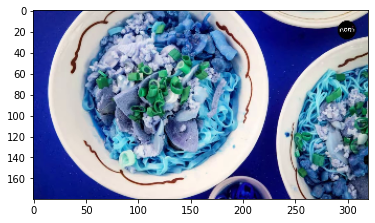

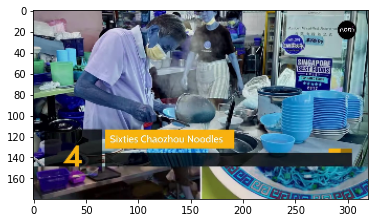

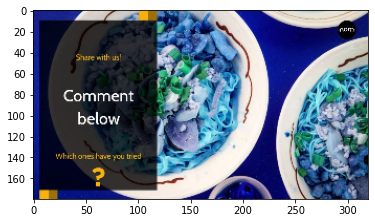

In [26]:
plt.imshow(resized_dishes[0])
plt.show()
plt.imshow(resized_dishes[1])
plt.show()
plt.imshow(resized_dishes[-1])

In [1]:
K = 4
kmeans = KMeans(n_clusters=K, random_state=0)
clusters = kmeans.fit(resized_dishes_2d.astype('uint8'))

NameError: name 'KMeans' is not defined

In [20]:
clusters.labels_

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
file_labels = pd.DataFrame({'files':sorted_dishes,'labels':clusters.labels_})
file_labels.head()

,files,labels
0,/home/shyann/code/seshyblack/live2eat/notebook...,0
1,/home/shyann/code/seshyblack/live2eat/notebook...,2
2,/home/shyann/code/seshyblack/live2eat/notebook...,2
3,/home/shyann/code/seshyblack/live2eat/notebook...,2
4,/home/shyann/code/seshyblack/live2eat/notebook...,2


In [22]:
file_labels['time'] = file_labels.files.str.split('/').str[-1].str.split('.').str[0]
file_labels.head()

,files,labels,time
0,/home/shyann/code/seshyblack/live2eat/notebook...,0,45200
1,/home/shyann/code/seshyblack/live2eat/notebook...,2,45300
2,/home/shyann/code/seshyblack/live2eat/notebook...,2,45400
3,/home/shyann/code/seshyblack/live2eat/notebook...,2,45500
4,/home/shyann/code/seshyblack/live2eat/notebook...,2,45600


In [25]:
median_image_times = file_labels.groupby('labels')['time'].apply(statistics.median_low)

for time in median_image_times:
    
    image = cv2.imread(f'{raw_data_dir}/{time}.0.jpg')
    cv2.imwrite(os.path.join(export_path, f'{time}.0.jpg'), image)
    cv2.waitKey(0)

In [26]:
folderName='data/'
    
for path, subdirs, files in os.walk(folderName):
    for name in files:
        path_local = os.path.join(path, name)
        blob_path = path_local.replace('\\','/')
        blob = bucket.blob(blob_path)
        blob.upload_from_filename(path_local)
    os.remove('/tmp/video.mp4') # Delete tmp resources to free memory

In [ ]:
# video_client = vi.VideoIntelligenceServiceClient(credentials=credentials)

In [15]:
# # only for display
# import matplotlib.pyplot as plt

# plt.imshow(X_start[1][:,:,::-1])

In [16]:
# credentials = service_account.Credentials.from_service_account_file(
#     '/home/shyann/code/seshyblack/live2eat/notebooks/lewagon-livetoeat-cdabf6bc01ed.json')

In [17]:
# fps = cam.get(cv2.CAP_PROP_FPS)
# frame_count = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
# duration = frame_count/fps
# duration

In [ ]:
# with st.form(key='params_for_api'):

#     pickup_date = st.date_input('pickup datetime',
#                                 value=datetime.datetime(
#                                     2012, 10, 6, 12, 10, 20))
#     pickup_time = st.time_input('pickup datetime',
#                                 value=datetime.datetime(
#                                     2012, 10, 6, 12, 10, 20))
#     pickup_datetime = f'{pickup_date} {pickup_time}'
#     pickup_longitude = st.number_input('pickup longitude', value=40.7614327)
#     pickup_latitude = st.number_input('pickup latitude', value=-73.9798156)
#     dropoff_longitude = st.number_input('dropoff longitude', value=40.6413111)
#     dropoff_latitude = st.number_input('dropoff latitude', value=-73.7803331)
#     passenger_count = st.number_input('passenger_count',
#                                       min_value=1,
#                                       max_value=8,
#                                       step=1,
#                                       value=1)

#     st.form_submit_button('Make prediction')

# params = dict(pickup_datetime=pickup_datetime,
#               pickup_longitude=pickup_longitude,
#               pickup_latitude=pickup_latitude,
#               dropoff_longitude=dropoff_longitude,
#               dropoff_latitude=dropoff_latitude,
#               passenger_count=passenger_count)

# wagon_cab_api_url = 'https://taxifare.lewagon.ai/predict'
# response = requests.get(wagon_cab_api_url, params=params)

# prediction = response.json()

# pred = prediction['fare']

# st.header(f'Total Calories: ${round(pred, 2)}')

In [ ]:
# with st.container():
#     col1, col2, col3, col4 = st.columns(4)

#     with col1:
#         st.checkbox('Select', key=1)
#         image1 = Image.open((os.path.join(export_path, dish_file_name[0]))
#         st.image(image1,caption=dish_predicted)
#         st.header('Calorie: 50')

#     with col2:
#         st.checkbox('Select', key=2)
#         image2 = Image.open((os.path.join(export_path, dish_file_name[1]))
#         st.image(image2,caption=dish_predicted)
#         st.header('Calorie: 50')

#     with col3:
#         st.checkbox('Select', key=3)
#         image3 = Image.open((os.path.join(export_path, dish_file_name[2]))
#         st.image(image3,caption=dish_predicted)
#         st.header('Calorie: 50')

#     with col4:
#         st.checkbox('Select', key=4)
#         image4 = Image.open((os.path.join(export_path, dish_file_name[3]))
#         st.image(image4,caption=dish_predicted)
#         st.header('Calorie: 50')


In [1]:
import os
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-12-02 13:56:51.008414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 13:56:51.011651: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/shyann/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
predict_data = test_datagen.flow_from_directory('/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data',
                                                batch_size=470,
                                                shuffle=False,
                                                class_mode='categorical')

Found 4 images belonging to 1 classes.


In [11]:
os.getcwd()

'/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd'

In [1]:
export_path = f'{dir}/data/predict_images'
export_path

'<built-in function dir>/data/predict_images'

In [8]:
dir

<function dir>

In [2]:
import glob

glob.glob(f'{export_path}/*.jpg')

[]

In [3]:
glob.glob('/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/*.jpg')

['/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/13000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/11500.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/12000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/15000.0.jpg']

In [20]:
os.path.join(os.getcwd()+'/data/predict_images'+ '/*.jpg')

'/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/*.jpg'

In [21]:
results=glob.glob(os.path.join(os.getcwd()+'/data/predict_images'+ '/*.jpg'))
results

['/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/13000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/11500.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/12000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/15000.0.jpg']

In [26]:
dir = os.getcwd()
raw_data_dir = f'{dir}/raw_data'
export_path = f'{dir}/data/predict_images'

In [37]:
dish_images = list(sorted(glob.glob(os.path.join(export_path + '/*.jpg')),
                       key=lambda s: int(s.split('/')[-1].split('.')[0])))
dish_images

['/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/11500.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/12000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/13000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/15000.0.jpg']

In [28]:
data = [{'dish_names': dish_names, 'dish_calories': dish_calories, 'prediction':prediction} for  dish_names, dish_calories,prediction in zip( dish_names, dish_calories, prediction)]


NameError: name 'dish_names' is not defined

In [9]:
max(data, key=lambda x:x['prediction'])

{'dish_images': '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/13000.0.jpg',
 'dish_names': 'BAK CHOR MEE',
 'dish_calories': '511 calories',
 'prediction': 5}

In [61]:
import pandas as pd
prediction_df=pd.DataFrame(list(zip(dish_images, dish_names, dish_calories,prediction)),columns=['image location','dish_names', 'dish_calories', 'prediction_score'] )
prediction_df[prediction_df['prediction_score'] == prediction_df['prediction_score'].max()]

,image location,dish_names,dish_calories,prediction_score
0,/home/shyann/code/seshyblack/live2eat/live2eat...,BAK CHOR MEE,511 calories,5


In [88]:
y =sorted(x, key = lambda x: x[2])

In [89]:
y[-1]

('BAK CHOR MEE', '511 calories', 5)

In [4]:
import glob

In [6]:
dir = os.getcwd()
raw_data_dir = f'{dir}/raw_data'
export_path = f'{dir}/data'

In [31]:


dish_names = [
    'BAK CHOR MEE', 'CHICKEN RICE', 'CHILLI CRAB', 'HOKKIEN MEE', 'KAYA TOAST'
]  # based on data.class_indices imagedatagen

dish_calories = [
    '511 calories', '607 calories', '1560 calories', '617 calories',
    '196 calories']

prediction = [
    5,4,3,2,1]

In [32]:
prediction_dict = [{
    'dish_names': dish_names,
    'dish_calories': dish_calories,
    'prediction': prediction
} for dish_names, dish_calories, prediction in zip(
    dish_names, dish_calories, prediction)]
predicted_dish = max(prediction_dict, key=lambda x: x['prediction'])

In [33]:
predicted_dish

{'dish_names': 'BAK CHOR MEE',
 'dish_calories': '511 calories',
 'prediction': 5}

In [34]:
dish_images

['/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/11500.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/12000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/13000.0.jpg',
 '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/15000.0.jpg']

In [35]:
predicted_dish['dish_images'] = dish_images[0]

In [36]:
predicted_dish

{'dish_names': 'BAK CHOR MEE',
 'dish_calories': '511 calories',
 'prediction': 5,
 'dish_images': '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/11500.0.jpg'}

In [41]:
list(enumerate(dish_images))


[(0,
  '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/11500.0.jpg'),
 (1,
  '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/12000.0.jpg'),
 (2,
  '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/13000.0.jpg'),
 (3,
  '/home/shyann/code/seshyblack/live2eat/live2eat_FrontEnd/data/predict_images/15000.0.jpg')]

In [46]:
import numpy as np

In [81]:
map(max, lists)
predicted_dish = list(map(max, lists))
predicted_dish

[5, 5]

In [79]:
classes = np.array(['BAK CHOR MEE', 'CHICKEN RICE', 'CHILLI CRAB', 'HOKKIEN MEE', 'KAYA TOAST'])

In [130]:
classes = np.array(['bak','mee','crab'])
predictions = np.array([[0.3,0.4,0.3],
                        [0.1,0.1,0.8],
                        [0.1,0.1,0.8]])

pred_maxed = predictions.argmax(1)
pred_maxed


array([1, 2, 2])

In [131]:
dish_names=classes[pred_maxed]
dish_names

array(['mee', 'crab', 'crab'], dtype='<U4')

In [132]:
dish_calories = [
    '511 calories', '607 calories', '1560 calories']

In [133]:
food_dictionary = dict(zip(classes,dish_calories))
food_dictionary

{'bak': '511 calories', 'mee': '607 calories', 'crab': '1560 calories'}

In [135]:

calories=list(map(food_dictionary.get,classes[pred_maxed]))
calories

['607 calories', '1560 calories', '1560 calories']

In [137]:
list(zip(dish_names,calories))

[('mee', '607 calories'), ('crab', '1560 calories'), ('crab', '1560 calories')]

In [ ]:
# dishes_predicted_list = []
# if len(prediction) > 0:
#     for i in prediction:

#         prediction_dict = [{
#             'dish_names': dish_names,
#             'dish_calories': dish_calories,
#             'prediction': prediction
#         } for dish_names, dish_calories, prediction in zip(
#             dish_names, dish_calories, prediction)]
#         predicted_dish = max(prediction_dict, key=lambda x: x['prediction'])
#         dishes_predicted_list.append(predicted_dish)

#     # for i, image in enumerate(dish_images):
#     #     dishes_predicted_list['dish_images'] = image